The goal of this notebook is to have a first functional workflow with a 'simple' model

__Roadmap__

1. Data prep into a tf.dataset object with the relevant features. Done with tokenizer.
    - sequence
    - masking 
    - offset mapping 


2. Create model via transfer learning
    

## Imports & Variables

In [2]:
#uncomment for colab
!pip install --quiet transformers

     |████████████████████████████████| 3.4 MB 36.0 MB/s 
     |████████████████████████████████| 67 kB 6.5 MB/s 
     |████████████████████████████████| 596 kB 58.0 MB/s 
     |████████████████████████████████| 3.3 MB 44.6 MB/s 
     |████████████████████████████████| 895 kB 72.0 MB/s 


In [3]:
#canonicals
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

#hugging face
from transformers import BertTokenizer, TFBertModel

#utils
from tqdm.notebook import tqdm_notebook

In [4]:
# Change this to work with a sample of the data or the full dataset
SAMPLE_MODE = True

#Max length of a discourse (refers to explorator nb)
DISCOURSE_LEN = 256

#Set TRAIN, VAL, TEST splits:
VAL_SPLIT=0.8
TEST_SPLIT=0.9

## Data

In [21]:
if SAMPLE_MODE:
    n_rows=15000-9
else: 
    n_rows=None

try:
  from google.colab import drive
  drive.mount('/content/drive')
  %cd /content/drive/MyDrive/data

  df = pd.read_csv('train_filled.csv',nrows=n_rows,index_col=0)

except:
  df = pd.read_csv('../raw_data/train_filled.csv',nrows=n_rows,index_col=0)

df.reset_index(drop=True, inplace=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/data


In [ ]:
df

In [23]:
## Splitting into train, val and test 

## setting for the exact right index : we don't wan't to split 
## an essay between 2 sets

idx_val=int(len(df)*VAL_SPLIT)
idx_test=int(len(df)*TEST_SPLIT)

for i in range(idx_val,idx_val+20):
    if df.loc[i,'id'] != df.loc[i+1,'id']:
        idx_val=i
        break
        
for i in range(idx_test,idx_test+20):
    if df.loc[i,'id'] != df.loc[i+1,'id']:
        idx_test=i
        break
        
#display(df.loc[idx_val-2:idx_val+2],df.loc[idx_test-2:idx_test+2],idx_val,idx_test)

idx_train=list(range(0,idx_val))
idx_val=list(range(idx_val,idx_test))
idx_test=list(range(idx_test,len(df)))

assert(len(idx_test)+len(idx_train)+len(idx_val)==len(df))

## Tokenizer

In [24]:
## create labels dict and map it
labels={l:i for i,l in enumerate(df.discourse_type.unique())}

df['label']=df['discourse_type'].map(labels)

In [25]:
## create x_train,x_test,x_val
x_train = df['discourse_text'].values[idx_train]
x_val = df['discourse_text'].values[idx_val]
x_test = df['discourse_text'].values[idx_test]

In [26]:
## create y_train, y_test, y_val 
y_train_ = df['label'].values[idx_train]
y_val_ = df['label'].values[idx_val]
y_test_ = df['label'].values[idx_test]

## ohe
y_train = np.zeros((len(idx_train),len(labels)))
y_val = np.zeros((len(idx_val),len(labels)))
y_test = np.zeros((len(idx_test),len(labels)))

y_train[np.arange(len(y_train_)),y_train_]=1
y_val[np.arange(len(y_val_)),y_val_]=1
y_test[np.arange(len(y_test_)),y_test_]=1

assert(y_test.shape[1]==8)

In [27]:
#initiate tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [28]:
## tokenize train,val,test
x_train_tok=tokenizer(list(x_train),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
             return_token_type_ids=False,return_tensors='tf')
x_val_tok=tokenizer(list(x_val),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
             return_token_type_ids=False,return_tensors='tf')
x_test_tok=tokenizer(list(x_test),truncation=True,max_length=DISCOURSE_LEN,padding='max_length',
             return_token_type_ids=False,return_tensors='tf')

In [29]:
x_train_tok

{'input_ids': <tf.Tensor: shape=(11997, 256), dtype=int32, numpy=
array([[  101,  2070,  2111, ...,     0,     0,     0],
       [  101,  2009,  2001, ...,     0,     0,     0],
       [  101,  1037, 15797, ...,     0,     0,     0],
       ...,
       [  101,  2174,  1010, ...,     0,     0,     0],
       [  101,  2005,  6013, ...,     0,     0,     0],
       [  101,  1999,  7091, ...,     0,     0,     0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(11997, 256), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [30]:
# Now we have a tf dataset object to train
tf_dataset = tf.data.Dataset.from_tensor_slices((x_train_tok,y_train))

## Modeling

In [31]:
pretrained_bert = TFBertModel.from_pretrained("bert-base-uncased")

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [74]:
def init_model():
    input_ids = tf.keras.layers.Input(shape=(DISCOURSE_LEN,),dtype='int32')
    attention_mask = tf.keras.layers.Input(shape=(DISCOURSE_LEN,),dtype='int32')
    x = pretrained_bert({'input_ids':input_ids,
                         'attention_mask':attention_mask})[0]
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(128, activation='relu')(x)
    x = tf.keras.layers.Dropout(.1)(x)
    x = tf.keras.layers.Dense(32, activation='relu')(x)
    output = tf.keras.layers.Dense(8, activation='softmax',name='outputs')(x)

    pretrained_bert.trainable=False
    
    model = tf.keras.Model(inputs={'input_ids':input_ids,
                                   'attention_mask':attention_mask},
                           outputs=output)
    
    return model

In [75]:
loss = tf.keras.metrics.CategoricalCrossentropy(name='categorical_crossentropy')
acc = tf.keras.metrics.CategoricalAccuracy('accuracy')
opt = tf.keras.optimizers.Adam()

model = init_model()

In [76]:
model.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 input_14 (InputLayer)          [(None, 256)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_15[0][0]',               
                                thPoolingAndCrossAt               'input_14[0][0]']               
                                tentions(last_hidde                                               
                                n_state=(None, 256,                                         

In [77]:
model.compile(optimizer=opt,loss='categorical_crossentropy',metrics=[acc])

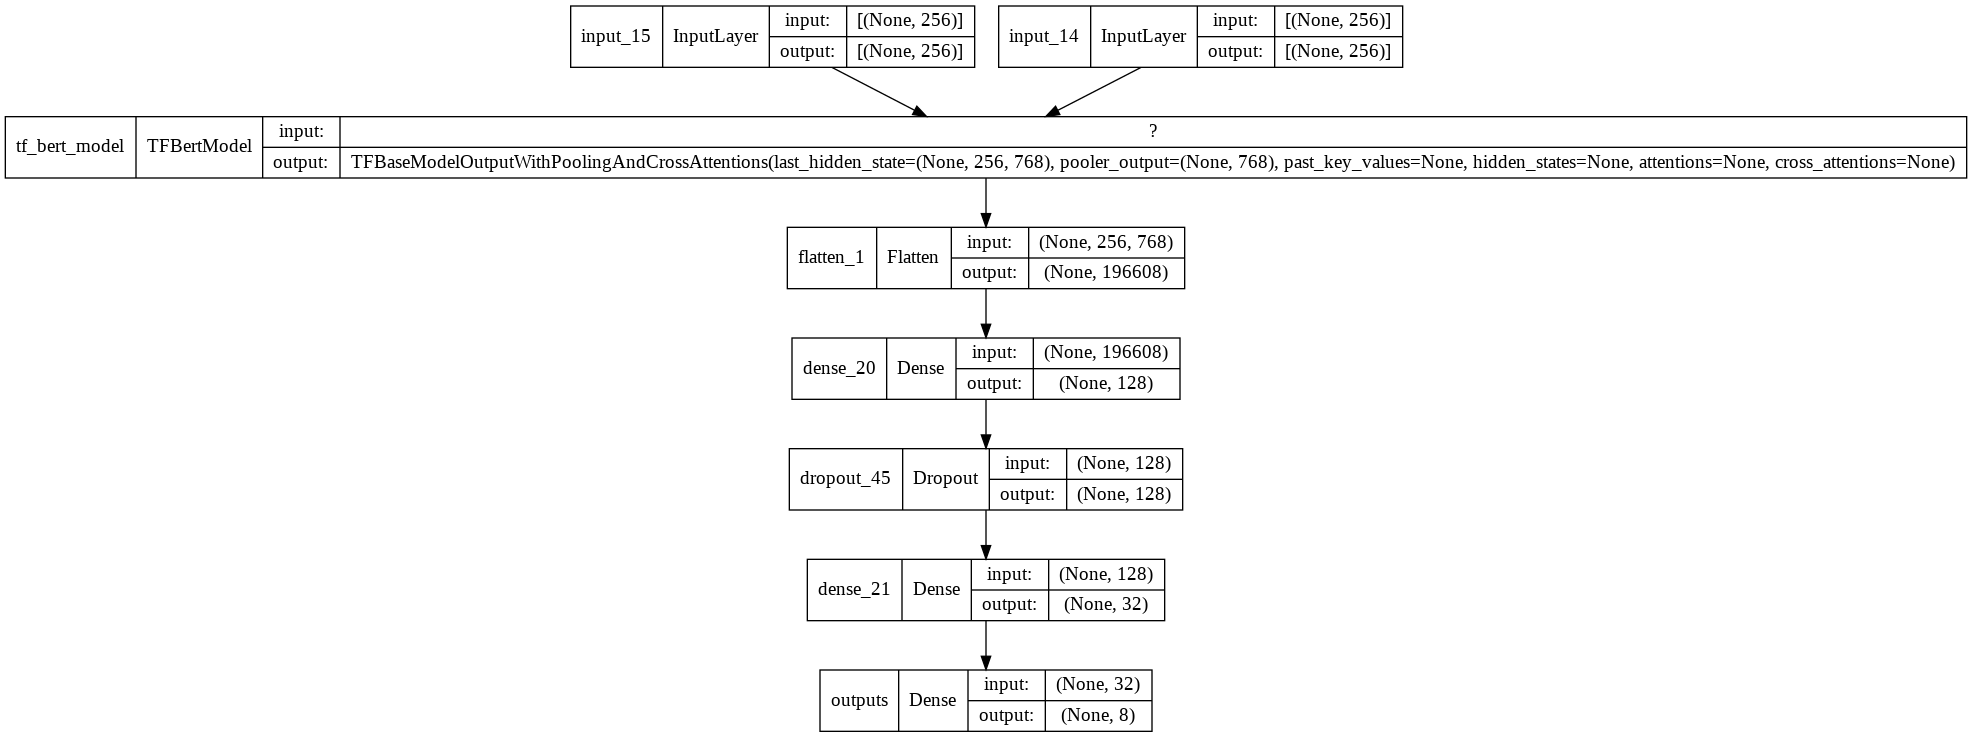

In [78]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [79]:
history = model.fit({'input_ids':x_train_tok['input_ids'],
                      'attention_mask':x_train_tok['attention_mask']},
                    y_train,validation_data=({'input_ids':x_val_tok['input_ids'],
                      'attention_mask':x_val_tok['attention_mask']},y_val),epochs=3,batch_size=32)

Epoch 1/3
375/375 [==============================] - 272s 696ms/step - loss: 1.7606 - accuracy: 0.5471 - val_loss: 1.1835 - val_accuracy: 0.6372
Epoch 2/3
375/375 [==============================] - 269s 718ms/step - loss: 1.1487 - accuracy: 0.6303 - val_loss: 1.1193 - val_accuracy: 0.6551
Epoch 3/3
375/375 [==============================] - 269s 717ms/step - loss: 1.0373 - accuracy: 0.6550 - val_loss: 1.1380 - val_accuracy: 0.6465


In [82]:
tf.saved_model.save(model,'data')

INFO:tensorflow:Assets written to: data/assets


INFO:tensorflow:Assets written to: data/assets
